In [2]:
import os, subprocess
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker, cm
import pandas as pd
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import leastsq
import tqdm

import pycbc.waveform
import cosmolopy.distance as cd

from gwaxion import physics

mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.family': 'serif',
    'font.size': 24,
    'font.serif': 'Computer Modern Roman'
}
matplotlib.rcParams.update(mplparams)

cosmo = {'omega_M_0':0.308, 'omega_lambda_0':0.692, 'omega_k_0':0.0, 'h':0.678}

## Preamble

In [3]:
def h95_viterbi(asd_f, T=None):
    # From Lilli: 95% detection efficiency h0 is 4.7e-26 at 201.2 Hz and an ASD of 4E-24 Sqrt[Hz], for T=80 days
    h95ref = 4.7E-26
    f95ref = 201.2
    asd95ref = 4E-24
    Tref = 80*physics.DAYSID_SI
    T = T if T is not None else Tref
    return h95ref * (asd95ref/asd_f) * (Tref/T)**0.25

def euclidean_horizon(h0, f=None, psd=None, asd=None, dref=5, T=None):
    """ Computes horizon (Mpc) assuming no redshift."""
    asd = asd if asd is not None else np.array([psd(freq)**0.5 for freq in np.array(f)])
    h95 = h95_viterbi(asd, T=T)
    return h0 * dref / h95

def z_to_dl(z):
    return cd.luminosity_distance(z, **cosmo)

## find redshift for a given luminosity distance
def findzfromDL(z, DL):
    return DL - cd.luminosity_distance(z, **cosmo)

## estimate the horizon for recursive evaluation in the main code
def horizon_dist_eval(h_ratio, d0, z0):
    guess_dist = d0*h_ratio
    guess_redshift, res = leastsq(findzfromDL, z0, args=guess_dist)
    return guess_redshift[0], guess_dist



In [4]:
def redshifted_bhb_threshold(h0_intr, f_intr, d_intr, psd, z, T=None, d=None, fmin=0):
    # redshift frequency
    z = np.array(z)
    f = f_intr/(1. + z)
    d = d if d is not None else z_to_dl(z)
    ratios = np.zeros(f.shape)
    asd_f = psd(f[f>fmin])**0.5
    thresh = h95_viterbi(asd_f, T=T)
    # rescale amplitude
    h0 = h0_intr * (d_intr / d[f>fmin])
    # compute ratio
    ratios[f>fmin] += h0 / thresh
    return ratios, d

def find_bhb_horizon(h0_intr, f_intr, d_intr=5, T=None, psd=None, z0=0.1, tolerance=0.01, fmin=0):
    """ Find horizon

    Arguments
    ---------
    h0_intr: float
        reference for intrinsic amplitude at `DL=d_ref`
    d_intr: float
        reference luminosity distance (Mpc)
    f_intr: float
        intrinsic signal frequency
    T: float
        integration time
    psd: object
        interpolated PSD from `interp1d`
    z0: float
        intial horizon redshift guess
    fmin: float
        min frequency for PSD interpolant (needed because frequencies get redshifted)
    """   
    # redshift signal to initial redshift guess `z0` and compute "detectability ratio", 
    # i.e. the ratio of the "intrinsic" amplitude to the detection threshold (at the redshifted frequency)
    z_guess = z0
    ratio_guess, d_guess = redshifted_bhb_threshold(h0_intr, f_intr, d_intr, psd, z_guess, T=T, fmin=fmin)
    # note: d_guess = d0 at this stage

    # evaluate the horizon recursively
    njump = 0
    while abs(ratio_guess - 1) > tolerance and njump < 10:  # require the fractional error within h_tolerance
        try:
            # horizon guess based on the old SNR
            z_guess, d_guess = horizon_dist_eval(ratio_guess, d_guess, z_guess)
            # pass d_guess below to avoid redundant computation
            ratio_guess, _ = redshifted_bhb_threshold(h0_intr, f_intr, d_intr, psd, z_guess, d=d_guess, T=T, fmin=fmin) 
        except:
            njump = 10
            #print "Will try interpolation."
        njump += 1
    horizon_redshift = z_guess 

    # at high redshift the recursive jumps lead to too big a jump for each step, and the recursive loops converge slowly.
    # so I interpolate the z-SNR curve directly.  
    if njump >= 10:
        #print "Recursive search for the horizon failed. Interpolation instead."
        zmin, zmax = 0.0001, 1000
        zs = np.linspace(zmin, zmax, 100)
        ratios = redshifted_bhb_threshold(h0_intr, f_intr, d_intr, psd, zs, T=T, fmin=fmin)[0]
        z_interp = interp1d(ratios, zs)
        try:
            horizon_redshift = z_interp(1)
        except ValueError, e:
            if 'below' in e:
                #print "Horizon further than z=%.1e" % zmax
                horizon_redshift = zmax
            elif 'above' in e:
                #print "Horizon closer than z=%.1e" % zmin
                print h0_intr
                horizon_redshift = zmin
    return horizon_redshift


In [5]:
def redshifted_cbc_threshold(m_intr, psd, z, T=None, d=None, fmin=10, fmax=1E4, delta_f=1E-2):
    # redshift mass
    m = m_intr*(1. + z)
    d = d if d is not None else z_to_dl(z)
    # get waveform
    try:
        hp, hc = pycbc.waveform.get_fd_waveform(approximant="IMRPhenomD", delta_f=delta_f, f_lower=fmin,
                                                mass1=0.5*m, mass2=0.5*m, distance=d)
    except RuntimeError:
        # mass outside range
        return 0, d
    # get SNR
    freq = hp.sample_frequencies.data
    isgood = (fmin<=freq) & (freq<=fmax)
    snr = 4 * delta_f * np.real(np.dot(hp[isgood], np.conjugate(hp[isgood]) / psd(freq[isgood])))
    inv_thresh = 0.125  # 1/8 
    return snr*inv_thresh, d

def find_cbc_horizon(m_intr, T=None, psd=None, z0=0.1, tolerance=0.01, fmin=1, fmax=1E4):
    """ Find horizon

    Arguments
    ---------
    h0_intr: float
        reference for intrinsic amplitude at `DL=d_ref`
    d_intr: float
        reference luminosity distance (Mpc)
    f_intr: float
        intrinsic signal frequency
    T: float
        integration time
    psd: object
        interpolated PSD from `interp1d`
    z0: float
        intial horizon redshift guess
    fmin: float
        min frequency for PSD interpolant (needed because frequencies get redshifted)
    """   
    # redshift signal to initial redshift guess `z0` and compute "detectability ratio", 
    # i.e. the ratio of the "intrinsic" amplitude to the detection threshold (at the redshifted frequency)
    z_guess = z0
    ratio_guess, d_guess = redshifted_cbc_threshold(m_intr, psd, z_guess, T=T, fmin=fmin, fmax=fmax)
    # note: d_guess = d0 at this stage

    # evaluate the horizon recursively
    njump = 0
    while abs(ratio_guess - 1) > tolerance and njump < 10:  # require the fractional error within h_tolerance
        try:
            # horizon guess based on the old SNR
            z_guess, d_guess = horizon_dist_eval(ratio_guess, d_guess, z_guess)
            # pass d_guess below to avoid redundant computation
            ratio_guess, _ = redshifted_cbc_threshold(m_intr, psd, z_guess, T=T, fmin=fmin, fmax=fmax) 
        except:
            njump = 10
            print "Will try interpolation."
        njump += 1
    horizon_redshift = z_guess 

    # at high redshift the recursive jumps lead to too big a jump for each step, and the recursive loops converge slowly.
    # so I interpolate the z-SNR curve directly.  
    if njump >= 10:
        print "Recursive search for the horizon failed. Interpolation instead."
        zmin, zmax = 0.0001, 1000
        zs = np.linspace(zmin, zmax, 1000)
        ratios = []
        for z in zs:
            ratios.append(redshifted_cbc_threshold(m_intr, psd, z, T=T, fmin=fmin, fmax=fmax)[0])
        z_interp = interp1d(ratios, zs)
        try:
            horizon_redshift = z_interp(1)
        except ValueError, e:
            if 'below' in e:
                print "Horizon further than z=%.1e" % zmax
                horizon_redshift = zmax
            elif 'above' in e:
                print "Horizon closer than z=%.1e" % zmin
                print h0_intr
                horizon_redshift = zmin
    return horizon_redshift

### Source frame

Load source-frame quantities from disk, or create if not found

In [91]:
dfpath = 'peak.hdf5'
if os.path.exists(dfpath):
    df_max = pd.read_hdf(dfpath, 'table', mode='r')
else:
    n_mass = 200
    n_chi = 200
    n_alpha = 1000

    distance = 5E6 * physics.PC_SI

    mbhs_array = np.logspace(0, 4, n_mass)
    chis_array = np.linspace(1E-4, 1, n_chi)

    alphas = np.linspace(0, 0.5, n_alpha)
    rows = []
    for mbh in mbhs_array:
        for chi in chis_array:
            h0s, fgws = physics.h0_scalar_brito(mbh, alphas, chi_i=chi, d=distance)
            hmax = np.nanmax(h0s)
            fmax = fgws[h0s==hmax][0]
            amax = alphas[h0s==hmax][0]
            rows.append({'mbh': mbh, 'chi': chi, 'h0': hmax, 'fgw': fmax, 'alpha': amax})
    df_max = pd.DataFrame(rows)
    df_max.to_hdf(dfpath, 'table', mode='w')

### aLIGO design

/Users/maxisi/custompy/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


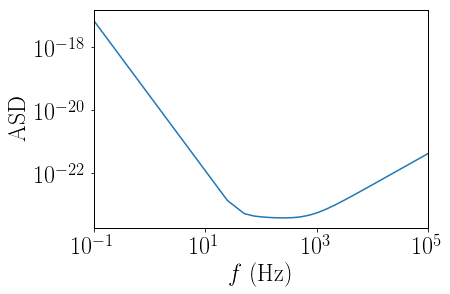

In [6]:
from lalsimulation import SimNoisePSDaLIGOZeroDetHighPower

flow = 0.1
fhig = 1E5
freqs = np.linspace(flow, fhig, 4000)

psd_des = np.array([SimNoisePSDaLIGOZeroDetHighPower(f) for f in freqs])
asd_des = psd_des**0.5

psd_des_interp = interp1d(freqs, psd_des)

fig, ax = plt.subplots(1)
ax.plot(freqs, asd_des)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(flow, fhig)
ax.set_xlabel(r'$f$ (Hz)')
ax.set_ylabel(r'ASD')
plt.show(fig)

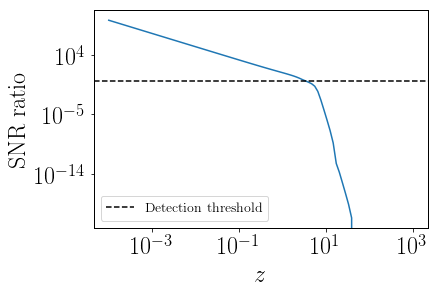

In [7]:
# check redshift interpolation

zmin, zmax = 0.0001, 100
zs = np.logspace(-4, 3, 100)
ratios = []
for z in zs:
    ratios.append(redshifted_cbc_threshold(100, psd_des_interp, z, fmin=10, fmax=5E3)[0])
z_interp = interp1d(zs, ratios)

fig, ax = plt.subplots(1)
ratios = np.linspace(min(ratios), max(ratios), 100)
ax.plot(zs, z_interp(zs))
ax.axhline(1, ls='--', color='k', label='Detection threshold')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'SNR ratio')
ax.set_xlabel(r'$z$')
ax.legend(loc='lower left', fontsize=14)
plt.show(fig)

In [8]:
# create horizon redshift interpolant
reload(physics)

h0s_array = np.logspace(-30, -23, 500)
fgws_array = np.logspace(2, 5, 500)

h0s, fgws, zs = [], [], []
with tqdm.tqdm(range(len(h0s)*len(fgws))) as pbar:
    for h0 in h0s_array:
        for fgw in fgws_array:
            zs.append(find_bhb_horizon(h0, fgw, psd=psd_des_interp, fmin=flow))
            h0s.append(h0)
            fgws.append(fgw)
            pbar.update()

250000it [29:58, 139.00it/s]


In [61]:
log_h = np.log10(h0s)
log_f = np.log10(fgws)
zs_a= np.array(zs)
zs_a[zs_a<=1E-4] = 1E-4
log_z = np.log10(zs_a)
hz_design_interp = interp2d(log_h, log_f, log_z)

/Users/maxisi/custompy/lib/python2.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=100,105 m=10000 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [66]:
print any(np.isnan(z))

False


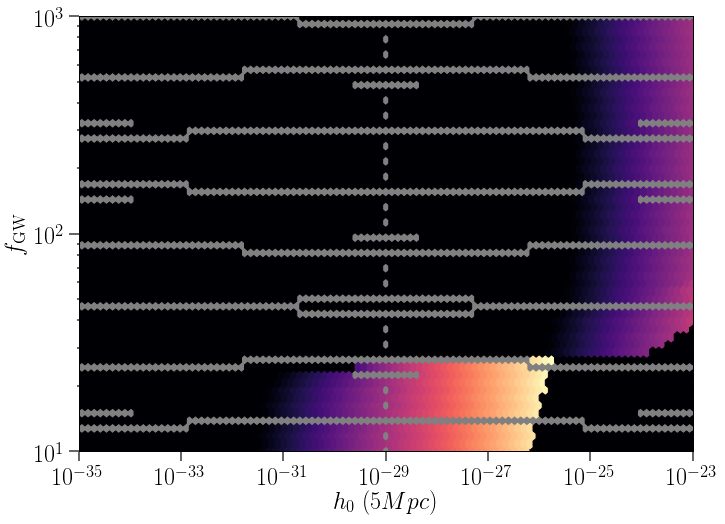

In [71]:
# plot interpolant
z = zs_a  #10**hz_design_interp(log_h, log_f)
zmin, zmax = 1E-3, z.max()
norm = matplotlib.colors.LogNorm(vmin=zmin, vmax=zmax)

fig, ax = plt.subplots(1, figsize=(11,8))
# plot contours
cm = ax.hexbin(h0s, fgws, C=z, cmap='magma', norm=norm,  xscale='log', yscale='log')

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
#b_ticks = np.logspace(hmin, hmax, 7) # np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
#cb = plt.colorbar(cm, norm=norm, label=r'aLIGO design range ($z$)')#, ticks=cb_ticks)
cb.ax.tick_params(labelsize=18) 

plt.ylabel(r'$f_{\rm GW}$')
plt.xlabel(r'$h_0$ (5 Mpc)')
ax.patch.set_facecolor("grey")

plt.xlim(min(h0s), max(h0s))
plt.ylim(10, 1E3)

ax.tick_params(axis='both', color='0.4', which='both', width=2)
ax.tick_params(axis='both', length=10)

cm.set_rasterized(True)

#fig.savefig('cmap_chi_mbh_range-design.pdf', bbox_inches='tight', dpi=400)

plt.show()
plt.close()


In [ ]:
# # get horizon

# # create copy of df with frequencies within interp range
# dfm = df_max[(df_max['h0']>0) & (~np.isnan(df_max['h0']) & (df_max['fgw']>flow))].copy()

# horizons_z = []
# import tqdm
# N=len(dfm)
# with tqdm.tqdm(range(N)) as pbar:
#     for h0, f in zip(dfm['h0'][:N], dfm['fgw'][:N]):
#         horizons_z.append(find_bhb_horizon(h0, f, psd=psd_des_interp, fmin=flow))
#         pbar.update()

  5%|▍         | 236229/4821020 [39:56<65:33:08, 19.43it/s] 

In [90]:
test_z = find_bhb_horizon(5E-26, 200, psd=psd_des_interp, fmin=flow)
test_d = z_to_dl(test_z)

print test_z
print test_d

0.0010968947830704565
4.854248587956958


In [86]:
hz = np.array(horizons_z)
hz[hz<0] = 0
hd = z_to_dl(hz)

dfm['horizon_z_des'] = hz
dfm['horizon_d_des'] = hd

dfm.to_hdf(dfpath+'_horizon_des.hdf5', 'table', mode='w')

### 3G detectors

In [ ]:
# load Voyager ASD
vals = np.loadtxt('noise_curves_T1500293-v10/voyager.txt')
freqs, asd_voy_array = vals[:,0], vals[:,1]

# create interpolant
asdv = interp1d(freqs, asd_voy_array)

fmin, fmax = freqs.min(), freqs.max()

asd = asdv(freqs)

fig, ax = plt.subplots(1)
ax.plot(freqs, asd)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fmin, fmax)
ax.set_xlabel(r'$f$ (Hz)')
ax.set_ylabel(r'ASD')
plt.show(fig)

print fmin, fmax

In [ ]:
# remove freqs outside interp range
dfmv = dfm[(dfm['fgw']>fmin) & (dfm['fgw']<fmax)].copy()
dfmv['dmax_voyager'] = horizon(dfmv['h0'], dfmv['fgw'], asd=asdv(dfmv['fgw'].values))

print dfmv['dmax_voyager'].min()
print dfmv['dmax_voyager'].max()

## Plots

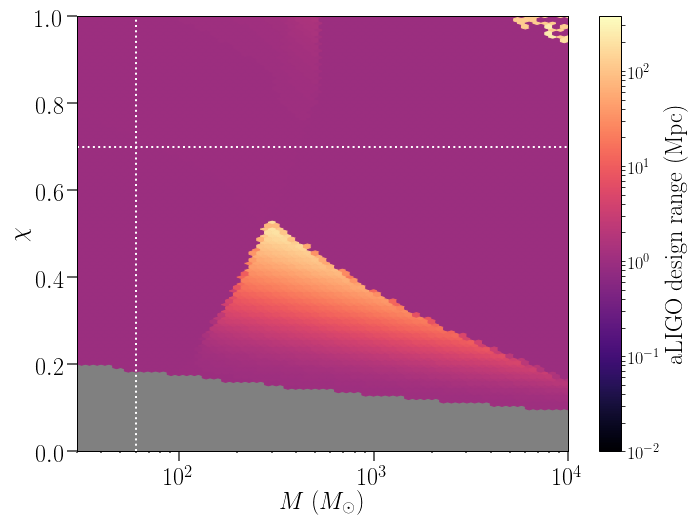

In [87]:
from matplotlib import ticker

z = dfm['horizon_z_des']
zmin, zmax = 1E-2, z.max()
norm = matplotlib.colors.LogNorm(vmin=zmin, vmax=zmax)

fig, ax = plt.subplots(1, figsize=(11,8))
# plot contours
cm = ax.hexbin(dfm['mbh'], dfm['chi'], C=z, cmap='magma', norm=norm,  xscale='log')

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
#b_ticks = np.logspace(hmin, hmax, 7) # np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'aLIGO design range ($z$)')#, ticks=cb_ticks)
cb.ax.tick_params(labelsize=18) 

plt.ylabel(r'$\chi$')
plt.xlabel(r'$M$ $(M_\odot)$')
ax.patch.set_facecolor("grey")

plt.xlim(30, 1E4)
plt.ylim(0, 1)

ax.tick_params(axis='both', color='0.4', which='both', width=2)
ax.tick_params(axis='both', length=10)

cm.set_rasterized(True)

fig.savefig('cmap_chi_mbh_range-design.pdf', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

## Peak emission

In [ ]:
# # create an array of BH masses

# n_mass = 5000
# n_chi = 1000
# n_alpha = 2000

# distance = 5E6 * physics.PC_SI

# mbhs_array = np.linspace(1, 1E4, n_mass)
# chis_array = np.linspace(1E-4, 1, n_chi)

# alphas = np.linspace(0, 0.5, n_alpha)

# df_list = []


# dfpath = 'peak.hdf5'
# if os.path.exists(dfpath):
#     df_max = pd.read_hdf(dfpath, 'table', mode='r')
# else:
#     rows = []
#     for mbh in mbhs_array:
#         for chi in chis_array:
#             h0s, fgws = physics.h0_scalar_brito(mbh, alphas, chi_i=chi, d=distance)
#             hmax = np.nanmax(h0s)
#             fmax = fgws[h0s==hmax][0]
#             amax = alphas[h0s==hmax][0]
#             rows.append({'mbh': mbh, 'chi': chi, 'h0': hmax, 'fgw': fmax, 'alpha': amax})
#     df_max = pd.DataFrame(rows)
#     df_max.to_hdf('peak.hdf5', 'table', mode='w')

In [ ]:
# h0_bound = df_max[(df_max['mbh']>10) & (df_max['mbh']<1E3)]['h0']
# print h0_bound.min()
# print h0_bound.max()